In [1]:
# Python script to estimate the STARS foam model parameter from experimental data. 
# This is a python adoption of a Julia script written by A.A. Eftekhari, see https://github.com/simulkade/foamparameters. 
# The optimization solver does not handle the bound constraints very well. It needs to be improved.

In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
from scipy import stats, optimize
from sklearn import linear_model
mpl.use('TkAgg')
import matplotlib.pyplot as plt
######################################################################
# Plot configurations
# mpl.style.use('classic')
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.dashed_pattern'] = [6, 6]
mpl.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
mpl.rcParams['lines.dotted_pattern'] = [1, 3]
mpl.rcParams['lines.scale_dashes'] = False

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
######################################################################
%matplotlib inline

In [11]:
def find_indices(vector, condition):
    return [i for i, elem in enumerate(vector) if condition(elem)]


def relative_sort(vector1, vector2):
    return [x for _, x in sorted(zip(vector1, vector2))]

##########################$######################################

def sws(s_w):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    n_size = np.size(s_w, 0)
    s_ws = np.zeros((n_size, 1))
    for i in range(0, len(s_w)):
        s = s_w[i]
        if s > swc and s < (1-sgr):
            s_ws[i, 0] = (s-swc)/(1-sgr-swc)
        elif s>=(1-sgr):
            s_ws[i, 0] = 1
    return s_ws


def krg(s_w):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    n_size = np.size(s_w, 0)
    kr_g = np.zeros((n_size, 1))
    for i in range(0, len(s_w)):
        s = s_w[i]
        if s >= swc:
            kr_g[i, 0] = krg0 * (1-sws(s)) ** ng
        elif s<swc:
            kr_g[i, 0] = 1+(krg0-1)/swc * s
    return kr_g


def krw(s_w):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    n_size = np.size(s_w, 0)
    kr_w = np.zeros((n_size, 1))
    for i in range(0, len(s_w)):
        s = s_w[i]
        if s <= (1 - sgr):
            kr_w[i, 0] = krw0 * sws(s) ** nw
        elif s > (1 - sgr):
            kr_w[i, 0] = (-(1 - krw0) / sgr * (1.0 - s) + 1.0)
    return kr_w


def dryout(x, sw):
    return 0.5 + np.arctan(x[1]*(sw-x[2]))/np.pi

########################################################################
# three parameter function (fmmob,epdry,fmdry)
def fm_mod_f2(s_w, f2):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    fm = 1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi)
    return fm


def fg_mod_f2(s_w, f2):
    krf = (krg(s_w) / fm_mod_f2(s_w, f2))
    fg = ((krf / mug[0, 0]) / (krw(s_w) / muw[0, 0] + krf / mug[0, 0]))
    return fg


def muf_mod_f2(s_w, f2):
    krf = (krg(s_w) / fm_mod_f2(s_w, f2))
    mu_foam = (1 / (krw(s_w) / muw[0, 0] + krf / mug[0, 0]))
    return mu_foam

########################################################################
# five parameter function (fmmob,epdry,fmdry,fmcap,epcap)
def fm_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    mu_f = np.reshape(mu_f, (np.size(mu_f), 1))
    fm = (1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi) *
          (f5[0] / (mu_f * u_t / sigma_wg)) ** f5[1])
    return fm


def fg_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
    fg = ((krf / mug[0, 0]) / (krw(s_w) / muw[0, 0] + krf / mug[0, 0]))
    return fg


def muf_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
    mu_foam = (1 / (krw(s_w) / muw[0, 0] + krf / mug[0, 0]))
    return mu_foam

########################################################################
# seven parameter function (fmmob,epdry,fmdry,fmcap,epcap,csurf,fmsurf,epsurf)

def fm_mod_f1f2f5(s_w, f1,f2, f5, mu_f, u_t):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    mu_f = np.reshape(mu_f, (np.size(mu_f), 1))
    fm = (1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi) *
          ((f5[0] / (mu_f * u_t / sigma_wg)) ** f5[1])*(csurf/f1[0])**f1[1])
    return fm

def fg_mod_f1f2f5(s_w, f1, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f1f2f5(s_w, f1, f2, f5, mu_f, u_t))
    fg = ((krf / mug[0, 0]) / (krw(s_w) / muw[0, 0] + krf / mug[0, 0]))
    return fg


def muf_mod_f1f2f5(s_w, f1, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f1f2f5(s_w, f1, f2, f5, mu_f, u_t))
    mu_foam = (1 / (krw(s_w) / muw[0, 0] + krf / mug[0, 0]))
    return mu_foam

In [5]:
data_file = '/Users/siavash/Rice/SurfactantConcentration/ExperimentalResults/AOSResults/data_AOS10E-1.csv'
header = ['fg', 'dp_tot', 'dp_mid', 'std_tot', 'std_mid', 'mu_tot', 'mu_mid', 'stdmu_tot', 'stdmu_mid', 'uw', 'ug', 'ut', 'p_mid', 'mu_water']

In [6]:
data = pd.read_csv(data_file, header=None, names=header)

In [7]:
sigma_wg = 0.03                                                                # IFT value                      [N/m]
p_mid = pd.to_numeric(data['p_mid'][1:])                                       # pressure at middle of the core [pa]
ug_r = pd.to_numeric(data['ug'][1:])                                           # corrected gas velocity         [m/s]
uw_r = pd.to_numeric(data['uw'][1:])                                           # corrected water velocity       [m/s]
u = pd.to_numeric(data['ut'][1:])                                              # corrected total velocity       [m/s]
fg_exp = pd.to_numeric(data['fg'][1:])                                         # corrected foam quality         [-]
dp_exp = pd.to_numeric(data['dp_tot'][1:])                                     # average pressure drop [Pa]
muf_exp = pd.to_numeric(data['mu_tot'][1:])                                    # foam apparent viscosity [Pa.s];
muw = pd.to_numeric(data['mu_water'][1:])                                      # corrected water viscosity      [pa s]
mug = np.zeros(np.size(fg_exp, 0))                                             # corrected gas viscosity        [pa s]
n_data = np.size(fg_exp, 0)

for i in range(0, len(mug)):
    mug[i] = CP.PropsSI("V", "T", 273.15+30, "P", p_mid[i+1], "N2")

In [8]:
muf_exp = relative_sort(fg_exp,muf_exp)
muf_exp = np.reshape(muf_exp, (len(muf_exp), 1))
u = relative_sort(fg_exp,u)
u = np.reshape(u, (len(u), 1))
dp_exp = relative_sort(fg_exp,dp_exp)
dp_exp = np.reshape(dp_exp, (len(dp_exp), 1))
muw = relative_sort(fg_exp,muw)
muw = np.reshape(muw, (len(muw), 1))
mug = relative_sort(fg_exp,mug)
mug = np.reshape(mug, (len(mug), 1))
p_mid = relative_sort(fg_exp,p_mid)
p_mid = np.reshape(p_mid, (len(p_mid), 1))
fg_exp = sorted(fg_exp)
fg_exp = np.reshape(fg_exp, (len(fg_exp), 1))

In [9]:
# low quality regime
ind_mu_max = muf_exp.argmax(axis=0)
fg_trans = fg_exp[ind_mu_max, 0]                                               # transition foam quality
ind_fg_low = find_indices(fg_exp, lambda e: e <= fg_trans)                     # low quality region indexes
fg_low = np.take(fg_exp, ind_fg_low)                                           # low quality region foam qualities
muf_low = np.take(muf_exp, ind_fg_low)                                         # low quality region apparent viscosities

# high quality regime
ind_fg_high = find_indices(fg_exp, lambda e: e >= fg_trans)                    # high quality region indexes
fg_high = np.take(fg_exp, ind_fg_high)                                         # high quality region foam qualities
muf_high = np.take(muf_exp, ind_fg_high)

# Relperm data
swc = 0.05                                                                     # connate water saturation [-]
sgr = 0.03                                                                     # irreducable gas saturation [-]
nw = 4.423                                                                     # Corey water exponent [-]
ng = 0.938                                                                     # Corey gas exponent [-]
krg0 = 0.587                                                                   # endpoint gas relative permeability [-]
krw0 = 0.720

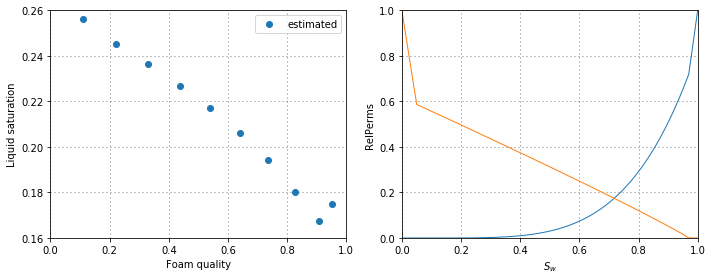

In [14]:
sw_exp = np.zeros((n_data, 1))
sw_plt = np.reshape(np.linspace(0.0,1.0, 100), (len(np.linspace(0.0,1.0, 100)), 1))
muf_trans = fg_trans
sw_trans = (1-swc-sgr)*(muw[ind_mu_max, 0]*(1-fg_trans)/(krw0*muf_trans))**(1/nw)+swc
for f in fg_exp:
    i = np.where(fg_exp == f)
    sw_exp[i, 0] = (1-swc-sgr)*(muw[i, 0]*(1-fg_exp[i, 0])/(krw0*muf_exp[i, 0]))**(1/nw)+swc


krg_plt = krg(sw_plt)
krw_plt = krw(sw_plt)

plt.figure(1, figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(fg_exp, sw_exp, "o")
plt.xlabel("Foam quality")
plt.ylabel("Liquid saturation")
plt.legend(["estimated"])
plt.grid()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(sw_plt, krw_plt, sw_plt, krg_plt)
plt.xlabel(r"$S_w$")
plt.ylabel("RelPerms")
plt.grid()
plt.tight_layout()

Optimization terminated successfully.
         Current function value: 1.008436
         Iterations: 495
         Function evaluations: 853
 final_simplex: (array([[  2.13657566e+03,   1.74961424e-01,   2.22605817e-04,
          2.00388065e+00,  -1.63424548e+00],
       [  2.13657557e+03,   1.74961424e-01,   2.22605817e-04,
          2.00388080e+00,  -1.63424555e+00],
       [  2.13657559e+03,   1.74961424e-01,   2.22605817e-04,
          2.00388078e+00,  -1.63424553e+00],
       [  2.13657572e+03,   1.74961424e-01,   2.22605816e-04,
          2.00388055e+00,  -1.63424544e+00],
       [  2.13657572e+03,   1.74961424e-01,   2.22605816e-04,
          2.00388055e+00,  -1.63424544e+00],
       [  2.13657560e+03,   1.74961424e-01,   2.22605817e-04,
          2.00388075e+00,  -1.63424552e+00]]), array([ 1.00843644,  1.00843644,  1.00843644,  1.00843644,  1.00843644,
        1.00843644]))
           fun: 1.0084364377116743
       message: 'Optimization terminated successfully.'
          nfev

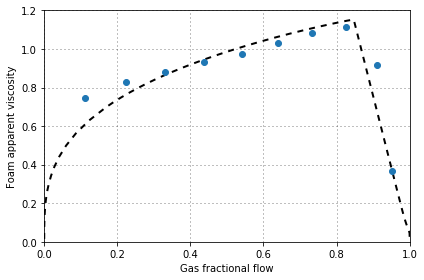

In [24]:
epdry = 1e5
csurf = 0.1
fmsurf= 2

labdaw = krw(sw_exp)/muw                                                  # water mobility
labdag = krg(sw_exp)/mug

# x0 = np.array([100000, 100000, 0.1696, 0.000175, 2.2222])
x0 = np.array([1000, 0.15, 0.0001, 2.5, 1])
bound = ((10, 1e8), (swc, sw_trans), (1e-4, 1e-2), (2, 4), (1e-4, 4))

w = np.ones((np.size(sw_exp), 1))
w[int(ind_mu_max)-4:int(ind_mu_max)] = 1e0
w[int(ind_mu_max)+1:int(ind_mu_max)+2] = 1e0


def misfit(x):
    return sum(w*(1.0-(1.0/(labdaw+labdag/(1.0+x[0]*(0.5+np.arctan(epdry*(sw_exp-x[1]))/np.pi)*(x[2]/(u*muf_exp/sigma_wg))**x[3]*(csurf/fmsurf)**x[4])))/muf_exp)**2)


# es = optimize.minimize(misfit, x0, method='CG', bounds=bound, options={'disp': True, 'eps': 1e-4})
es = optimize.minimize(misfit, x0, method='Nelder-Mead', bounds=bound, options={'disp': True})

print(es)
foam_param = np.zeros((6, 0))
foam_param = np.insert(es.x, 1, epdry)
foam_param = np.reshape(foam_param, (len(foam_param), 1))

sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 100),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 100))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 100))

n1 = np.size(sw_val)
muf_opt = np.zeros((n1, 1))
u_min = np.min(u)
u_max = np.max(u)
u_ave = float(np.mean(u))

F22 = [foam_param[0, 0], foam_param[1, 0], foam_param[2, 0]]
F52 = [foam_param[3, 0], foam_param[4, 0]]
F12 = [fmsurf, foam_param[5, 0]]

print(foam_param)
for i in range(0, n1):
    sw_p = float(sw_val[i])

    def fmu2(x):
        return float(x - muf_mod_f1f2f5(sw_p, F12, F22, F52, x, u_ave))

    sol = optimize.root(fmu2, 0.9)
    muf_opt[i, 0] = sol.x


fg_opt = fg_mod_f1f2f5(sw_val, F12, F22, F52, muf_opt, u_ave)
muf_mod_opt = muf_mod_f1f2f5(sw_val, F12, F22, F52, muf_opt, u_ave)

plt.figure(3)
plt.plot(fg_opt, muf_mod_opt, "k--", linewidth=2)
plt.plot(fg_exp, muf_exp, "o")
plt.ylabel("Foam apparent viscosity")
plt.xlabel("Gas fractional flow")
plt.grid()
plt.tight_layout()

plt.show()
